In [1]:
#!pip uninstall torch

In [ ]:
!pip install torch==1.10.0

In [3]:
!pip install transformers

In [4]:
# installed sentencepiece tokenizer
!pip install sentencepiece

In [5]:
import os
import math

In [6]:
import torch
from torch.nn import CrossEntropyLoss
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler

In [7]:
from transformers import AdamW, XLNetTokenizer, XLNetConfig, get_linear_schedule_with_warmup

In [8]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 3)
model = model.to(device)

#We should TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [10]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn import metrics

In [11]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm, trange

In [12]:
# data visualization at the time of data import and model metrics
import seaborn as sns
# we can set the parameters for each plot 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

# model metrics to be defined 
from sklearn.metrics import confusion_matrix, classification_report

# showing the plots in the notebook itself
%matplotlib inline
# retina is a style shape
%config InlineBackend.figure_format='retina'

# setting the visualizing settings first hand
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# getting the colors we need for plots
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# define the color palette
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# size can be set accordingly
rcParams['figure.figsize'] = 12, 8

# generating pseudo random numbers
RANDOM_SEED = 42

# np arrays , tensors
np.random.seed(RANDOM_SEED)

In [46]:
# making separate dataframes for the three files 
# which are already pre processed
train = pd.read_csv("/content/Train_data_intent1.csv")
valid = pd.read_csv("/content/Valid_data_intent1.csv")
test = pd.read_csv("/content/Test_data_intent1.csv")

In [14]:
# appending the valid df to train df
train = train

In [15]:
# training df has 13784 no. of records
train.shape

(478, 2)

In [16]:
train.head()

,body,intent_1
0,Have you changed the system at all? Our qualit...,Asking for information
1,overall FOS is 1.7,Providing information
2,That is what my document specifies. I will kee...,Providing information
3,An uncertain relationship to increase the DS? ...,Asking for information
4,"aaargh I keep forgetting I have to click ""chec...",Providing information


In [47]:
# taking unique intents and convert them to list 
classes = test.intent_1.unique().tolist()

In [48]:
classes

['Asking for information', 'Providing information', 'NAN']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


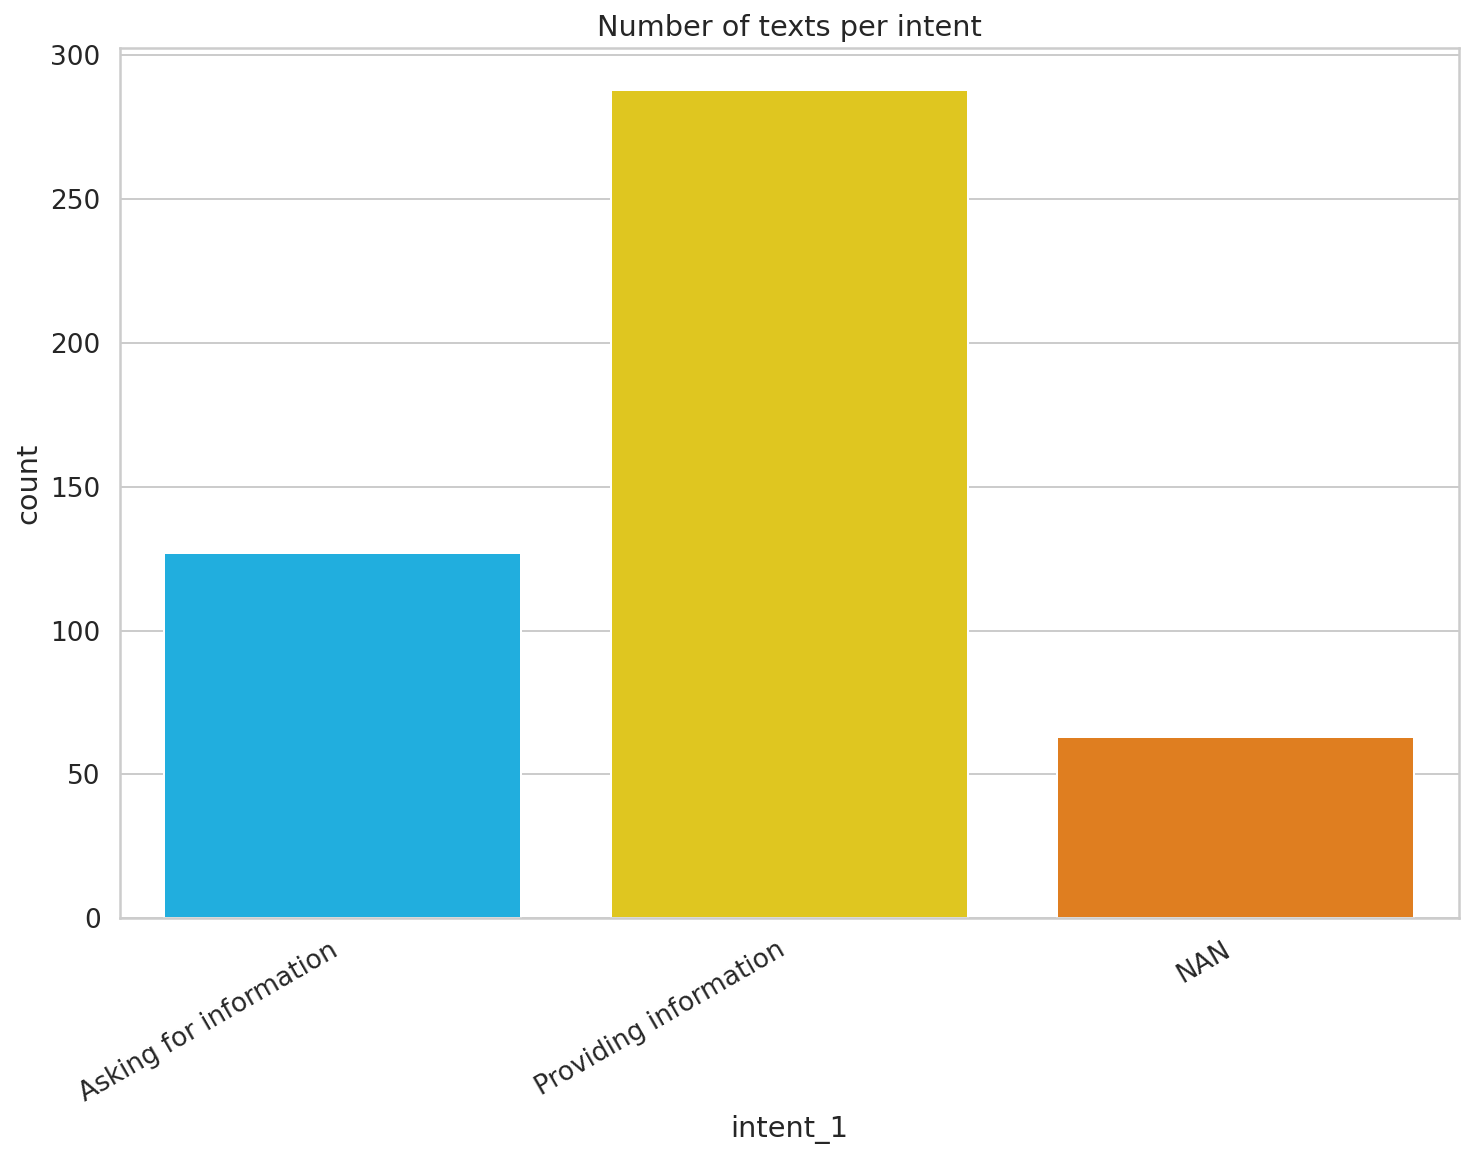

In [19]:
# let's check how the datset looks , if it is imbalanced or not
# making a chart to see how many texts are for each of the seven intents
chart = sns.countplot(train.intent_1, palette=HAPPY_COLORS_PALETTE)

# setting title of the chart
plt.title("Number of texts per intent")

# setting labels to the bottom at an angle of 30 degrees
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [20]:
train['body']= train['body'].astype('str')
train['intent_1']= train['intent_1'].astype("category")
train['intent_1']= train['intent_1'].cat.codes

In [21]:
valid['body']= valid['body'].astype('str')
valid['intent_1']= valid['intent_1'].astype("category")
valid['intent_1']= valid['intent_1'].cat.codes

In [22]:
test['body']= test['body'].astype('str')
test['intent_1']= test['intent_1'].astype("category")
test['intent_1']= test['intent_1'].cat.codes

In [23]:
# make a folder named model for moving all the stuff 
os.makedirs("model", exist_ok=True)

In [24]:
# moving the stuff from bert to model folder 
#!mv uncased_L-12_H-768_A-12/ model

In [25]:
class IntentDetectionData(Dataset):

    def __init__(self, body, intent, tokenizer, max_len):
        self.body = body
        self.targets = intent
        self.tokenizer = tokenizer
        self.max_len = max_len

    #Magic function returning length of a dataframe
    def __len__(self):
        return len(self.body)
    
    #Magic function returning specific instance and intent
    def __getitem__(self, item):
        body = str(self.body[item])
        target = self.targets[item]

  #Encode the body and generate mask
        encoding = self.tokenizer.encode_plus(body,add_special_tokens=True,truncation=True,max_length=self.max_len,return_token_type_ids=False,pad_to_max_length=False,return_attention_mask=True,return_tensors='pt')
        input_encode_seq = torch.tensor(pad_sequences(encoding['input_ids'], maxlen=self.max_len, dtype=torch.Tensor ,truncating="post",padding="post").astype(dtype = 'int64'))
        attention_mask = torch.tensor(pad_sequences(encoding['attention_mask'], maxlen=self.max_len , dtype=torch.Tensor ,truncating="post",padding="post").astype(dtype = 'int64'))
        intent_categorical_id = torch.tensor(target, dtype=torch.long)

        return {
        'review_text': body,
        'input_ids': input_encode_seq,
        'attention_mask': attention_mask.flatten(),
        'targets': intent_categorical_id
        }


In [26]:
def _prepare(train_data, tokenizer, max_len, batch_size):
  tensor_dictionary = IntentDetectionData(train_data.body,train_data.intent_1,tokenizer,max_len=max_len)
  #Calling the Dataloader method with tensor dictionary
  output_datalaoder = DataLoader(tensor_dictionary,batch_size=batch_size,num_workers=2)
  return output_datalaoder

In [27]:
max_len=128
batch_size=2

train_data_tensor = _prepare(train, tokenizer, max_len, batch_size)
val_data_tensor = _prepare(valid, tokenizer, max_len, batch_size)
test_data_tensor = _prepare(test, tokenizer, max_len, batch_size)

In [28]:
data_in_batch = next(iter(train_data_tensor))
data_in_batch.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [29]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
                                ]


optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-5)

In [30]:
Epochs = 8

total_steps = len(train_data_tensor) * Epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [31]:
def train_model(model, tensor_data_set, optimizer, device, scheduler, num_of_training_data):
    losses = []
    acc = 0
    counter = 0
    model = model.train()

    for d in tensor_data_set:
        input_ids = d["input_ids"].reshape(batch_size,max_len).to(device) #reshape(batch_size * tensor sequence length)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1
        #Calculating the accuracy and loss for batch
    return acc/counter, np.mean(losses)

In [32]:
def eval_model(model, tensor_data_set, device, num_of_training_data):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in tensor_data_set:
            input_ids = d["input_ids"].reshape(batch_size,max_len).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc/counter, np.mean(losses)


In [33]:
%%time
patience=3
history = defaultdict(list)
best_accuracy = 0
accuracy_over_epoch =[]
loss_over_epoch =[]
for epoch in range(Epochs):
    print(f"Batch size is {batch_size}")
    print(f'Currenly running Epoch {epoch + 1}/{Epochs}')
    print('=====' * 10)
    #calling the train model function
    train_acc, train_loss = train_model(model,train_data_tensor,optimizer,device,scheduler,len(train))
    accuracy_over_epoch.append(train_acc)
    loss_over_epoch.append(train_loss)
    print(f'Train loss of batch is {train_loss} and Train accuracy of batch is {train_acc}')
    val_acc, val_loss = eval_model(model,val_data_tensor,device,len(valid))
    print(f'Val loss of batch is {val_loss} and val accuracy of batch is {val_acc}')
    #Append the training info to ditioanry
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save({'epoch': epoch+1,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()},'/content/model/xlnet_model.pth')
        best_accuracy = val_acc
    elif val_acc<best_accuracy:
         patience-=patience
    if patience==0:
       break

Batch size is 2
Currenly running Epoch 1/8
Train loss of batch is 0.8472963478279818 and Train accuracy of batch is 0.7217573221757322
Val loss of batch is 0.7490418277884601 and val accuracy of batch is 0.84
Batch size is 2
Currenly running Epoch 2/8
Train loss of batch is 0.46115268187592034 and Train accuracy of batch is 0.9225941422594143
Val loss of batch is 0.7694380882233963 and val accuracy of batch is 0.88
Batch size is 2
Currenly running Epoch 3/8
Train loss of batch is 0.31282935614304186 and Train accuracy of batch is 0.9476987447698745
Val loss of batch is 1.0013933330657891 and val accuracy of batch is 0.84
CPU times: user 1min 13s, sys: 14.9 s, total: 1min 28s
Wall time: 1min 40s


In [34]:
torch.save(model, '/content/model/xlnet_model.pt')

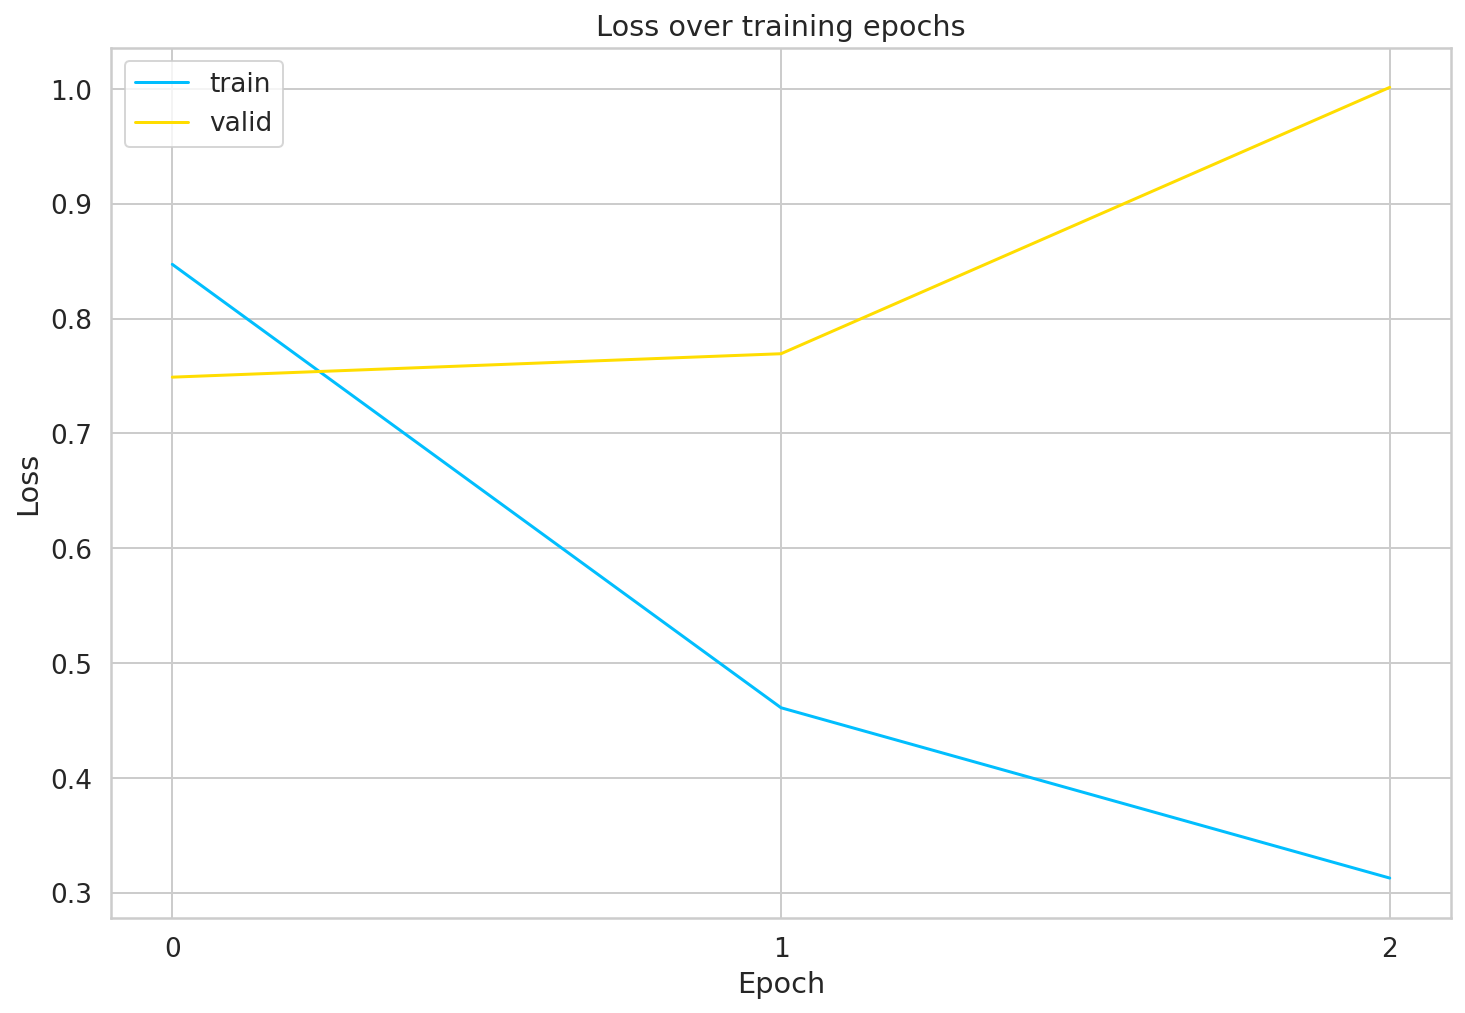

In [40]:
# how loss has decreased with epoch number 
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history['train_loss'])
ax.plot(history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Loss over training epochs')
plt.show();

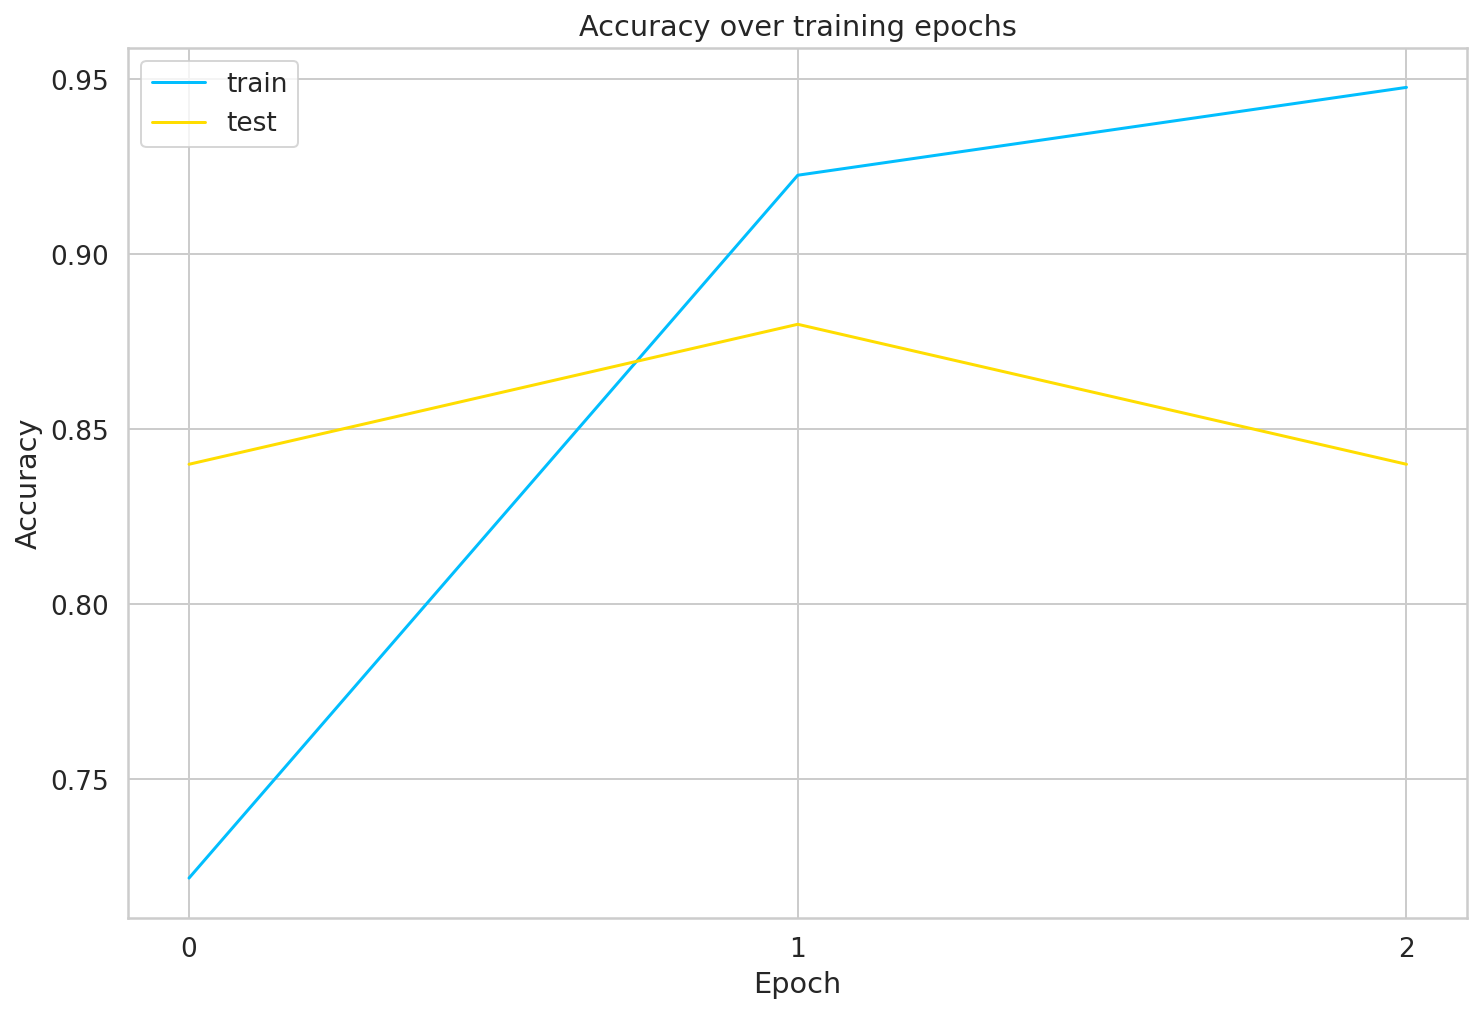

In [41]:
# graph for accuracy against the epoch number 
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history['train_acc'])
ax.plot(history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [42]:
def prediction_fun(model, tensor_data_set):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tensor_data_set:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(batch_size,max_len).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [43]:
y_review_texts, y_pred, y_pred_probs, y_test = prediction_fun(
  model,
  test_data_tensor
)

In [55]:
class_names =['Asking for information','NAN', 'Providing information']

In [50]:
# print classification report 
print(classification_report(y_test, y_pred, target_names=["Asking for information","NAN","Providing information"]))

                        precision    recall  f1-score   support

Asking for information       0.82      0.86      0.84        21
                   NAN       0.73      0.89      0.80         9
 Providing information       0.95      0.89      0.92        46

              accuracy                           0.88        76
             macro avg       0.83      0.88      0.85        76
          weighted avg       0.89      0.88      0.88        76



In [56]:
# create a confusion matrix and chart it
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=
                     ['Asking for information','NAN', 'Providing information']
                     )

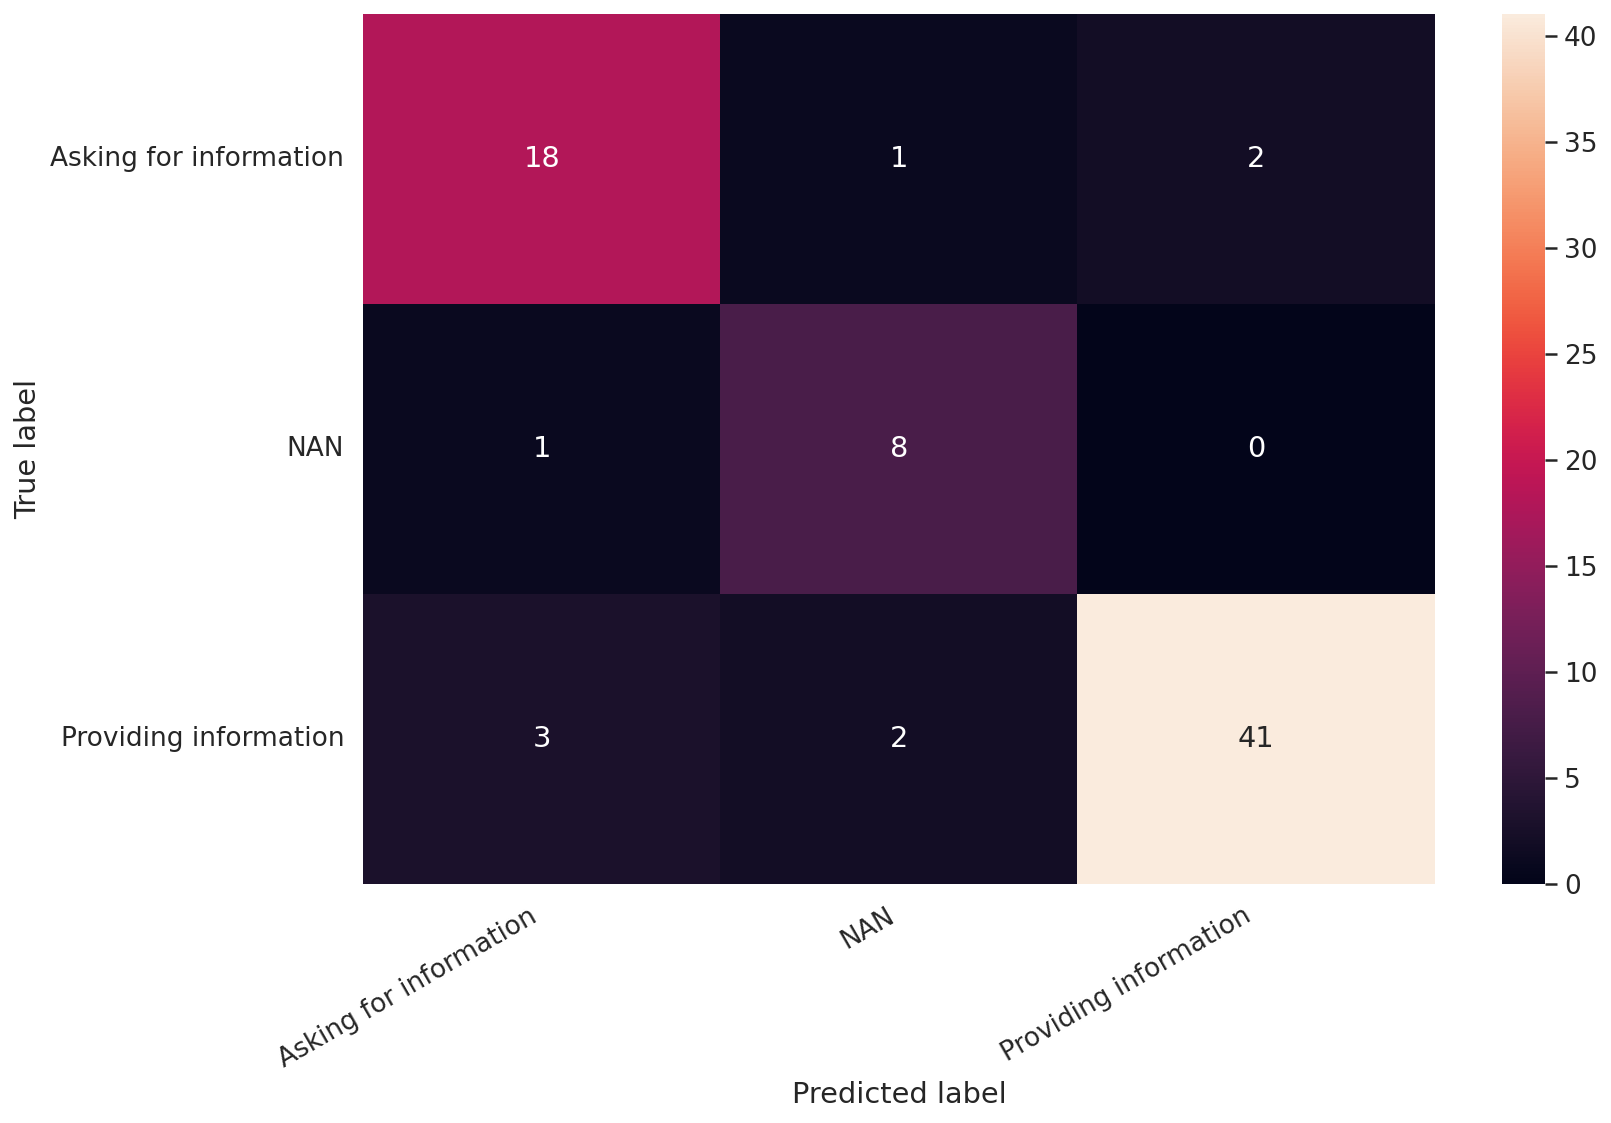

In [57]:
# using a heatmap from seaborn to visualize the confusion matric
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
df = pd.read_csv("/content/predict_engine.csv")

In [ ]:
def prepare_test(text):
    x = []
    m = []
    text_df = text
    # iterate over each row and use tqdm to visualize that
    for _, row in tqdm(text_df.iterrows()):
      # extracting the seq. and labels
      text = row['Body']
      encoded_review = tokenizer.encode_plus(text,max_length=max_len,add_special_tokens=True,return_token_type_ids=False,pad_to_max_length=False,return_attention_mask=True,return_tensors='pt')
      input_ids = torch.tensor(pad_sequences(encoded_review['input_ids'], maxlen=max_len, dtype=torch.Tensor ,truncating="post",padding="post").astype(dtype = 'int64'))
      input_ids = input_ids.reshape(1,max_len).to(device)
      attention_mask = torch.tensor(pad_sequences(encoded_review['attention_mask'], maxlen=max_len, dtype=torch.Tensor ,truncating="post",padding="post").astype(dtype = 'int64'))
      attention_mask = attention_mask.to(device)
      x.append(input_ids)
      m.append(attention_mask)
    return x,m


In [ ]:
input_tensor_lst,mask_tensor = prepare_test(df)

In [ ]:
df['Intent1']=""

In [ ]:
for i, input_tens_m in enumerate(zip(input_tensor_lst, mask_tensor)):
  outputs = model(input_ids=input_tens_m[0], attention_mask=input_tens_m[1])
  outputs = outputs[0][0].cpu().detach()
  probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
  _, prediction = torch.max(outputs, dim =-1)
  df['Intent1'][i] = class_names[prediction]

In [ ]:
df.head()

In [ ]:
df.to_csv('engine_predict_intent1_xlnet.csv')

In [58]:
def check_intent(text):
 
  encoded_review = tokenizer.encode_plus(text,max_length=max_len,add_special_tokens=True,return_token_type_ids=False,pad_to_max_length=False,return_attention_mask=True,return_tensors='pt')
  input_ids = torch.tensor(pad_sequences(encoded_review['input_ids'], maxlen=max_len, dtype=torch.Tensor ,truncating="post",padding="post").astype(dtype = 'int64'))
  input_ids = input_ids.reshape(1,max_len).to(device)
  attention_mask = torch.tensor(pad_sequences(encoded_review['attention_mask'], maxlen=max_len, dtype=torch.Tensor ,truncating="post",padding="post").astype(dtype = 'int64'))
  attention_mask = attention_mask.to(device)
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  outputs = outputs[0][0].cpu().detach()
  print(f"output of last layer of network{outputs}")
  probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
  print(f"output of softmax i.e logits {probs}")
  _, prediction = torch.max(outputs, dim =-1)
  print("-----------------------------------------")
  print(f'Message : {text}')
  print("-----------------------------------------")
  print(f'Intent  : {class_names[prediction]}')

In [59]:
check_intent("Do you have a value for the bore diameter?")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


output of last layer of networktensor([ 5.1296, -4.1699, -1.9247])
output of softmax i.e logits [0.9990457892417908, 9.138506720773876e-05, 0.0008628659998066723]
-----------------------------------------
Message : Do you have a value for the bore diameter?
-----------------------------------------
Intent  : Asking for information
